In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime, date
from scipy import stats
from sklearn.feature_selection import chi2
from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import itertools
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from statistics import*

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [3]:
print(" Shape of training dataframe: ", df.shape)
print(" Shape of testing dataframe: ", test.shape)
# Drop duplicates
df.drop_duplicates()
test.drop_duplicates()
print(df.shape)
print(test.shape)

 Shape of training dataframe:  (233154, 41)
 Shape of testing dataframe:  (112392, 40)
(233154, 41)
(112392, 40)


In [4]:
df.head()

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-1984,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-1985,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-1985,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-1993,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-1977,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UNIQUEID                             233154 non-null  int64  
 1   DISBURSED_AMOUNT                     233154 non-null  int64  
 2   ASSET_COST                           233154 non-null  int64  
 3   LTV                                  233154 non-null  float64
 4   BRANCH_ID                            233154 non-null  int64  
 5   SUPPLIER_ID                          233154 non-null  int64  
 6   MANUFACTURER_ID                      233154 non-null  int64  
 7   CURRENT_PINCODE_ID                   233154 non-null  int64  
 8   DATE_OF_BIRTH                        233154 non-null  object 
 9   EMPLOYMENT_TYPE                      225493 non-null  object 
 10  DISBURSAL_DATE                       233154 non-null  object 
 11  STATE_ID     

In [6]:
null= df.isnull().sum().sort_values(ascending=False)
total =df.shape[0]
percent_missing= (df.isnull().sum()/total).sort_values(ascending=False)

missing_data= pd.concat([null, percent_missing], axis=1, keys=['Number', 'Percent'])

missing_data.reset_index(inplace=True)
missing_data= missing_data.rename(columns= { "index": " Attributes"})
 
print ("Null Values in each column:\n", missing_data.sort_values(by ='Number', ascending = False))

Null Values in each column:
                              Attributes  Number   Percent
0                       EMPLOYMENT_TYPE    7661  0.032858
21        PERFORM_CNS_SCORE_DESCRIPTION       0  0.000000
23                       DISBURSAL_DATE       0  0.000000
24                           ASSET_COST       0  0.000000
25                                  LTV       0  0.000000
26                            BRANCH_ID       0  0.000000
27                          SUPPLIER_ID       0  0.000000
28                      MANUFACTURER_ID       0  0.000000
29                   CURRENT_PINCODE_ID       0  0.000000
30                        DATE_OF_BIRTH       0  0.000000
31                             STATE_ID       0  0.000000
32                    PERFORM_CNS_SCORE       0  0.000000
33                     EMPLOYEE_CODE_ID       0  0.000000
34                    MOBILENO_AVL_FLAG       0  0.000000
35                          AADHAR_FLAG       0  0.000000
36                             PAN_FLAG    

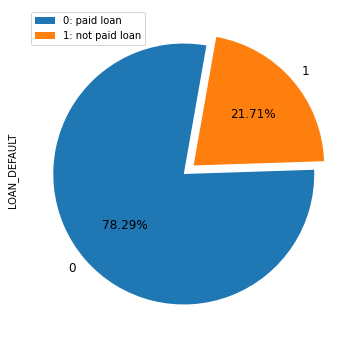

In [7]:
df['LOAN_DEFAULT'].value_counts().plot(kind='pie', subplots=True, autopct='%1.2f%%', explode= (0.05, 0.05), startangle=80, legend=True, fontsize=12, figsize=(14,6), textprops={'color':"black"})
plt.legend(["0: paid loan","1: not paid loan"]);

In [8]:
### The dataset have several features which are of no use in EDA and 
#visualizations of the dataset. What we need to do is the seperate those
#columns with datatypes int64 and float 64
#Further we know that numerical dataset is of two types :
#* Continous
#* Discrete
#There is no rule of classifying the datasets into these categories but for our
#use we can assume that columns which have less than 30 unique values is 
#considered discrete and the rest are continous

In [9]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
numerical_features

Index(['UNIQUEID', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'BRANCH_ID',
       'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID', 'STATE_ID',
       'EMPLOYEE_CODE_ID', 'MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG',
       'VOTERID_FLAG', 'DRIVING_FLAG', 'PASSPORT_FLAG', 'PERFORM_CNS_SCORE',
       'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS',
       'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT',
       'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS',
       'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT',
       'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
       'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'NO_OF_INQUIRIES',
       'LOAN_DEFAULT'],
      dtype='object')

In [10]:
discrete_features = [feature for feature in numerical_features if len(df[feature].unique())<30]
discrete_features

['MANUFACTURER_ID',
 'STATE_ID',
 'MOBILENO_AVL_FLAG',
 'AADHAR_FLAG',
 'PAN_FLAG',
 'VOTERID_FLAG',
 'DRIVING_FLAG',
 'PASSPORT_FLAG',
 'PRI_OVERDUE_ACCTS',
 'SEC_ACTIVE_ACCTS',
 'SEC_OVERDUE_ACCTS',
 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS',
 'NO_OF_INQUIRIES',
 'LOAN_DEFAULT']

In [11]:
df.isna().sum()

UNIQUEID                                  0
DISBURSED_AMOUNT                          0
ASSET_COST                                0
LTV                                       0
BRANCH_ID                                 0
SUPPLIER_ID                               0
MANUFACTURER_ID                           0
CURRENT_PINCODE_ID                        0
DATE_OF_BIRTH                             0
EMPLOYMENT_TYPE                        7661
DISBURSAL_DATE                            0
STATE_ID                                  0
EMPLOYEE_CODE_ID                          0
MOBILENO_AVL_FLAG                         0
AADHAR_FLAG                               0
PAN_FLAG                                  0
VOTERID_FLAG                              0
DRIVING_FLAG                              0
PASSPORT_FLAG                             0
PERFORM_CNS_SCORE                         0
PERFORM_CNS_SCORE_DESCRIPTION             0
PRI_NO_OF_ACCTS                           0
PRI_ACTIVE_ACCTS                

In [12]:
df = df[df['EMPLOYMENT_TYPE'].notna()]

In [13]:
g1=df.groupby('LOAN_DEFAULT')

In [14]:
loan_default_group=g1.describe()
loan_default_group.to_excel('loanDefaultGroupBy.xlsx')
g1.describe()

UNIQUEID                                                    \
                 count           mean           std       min        25%   
LOAN_DEFAULT                                                               
0             176526.0  534465.757260  67576.438092  417428.0  476205.25   
1              48967.0  540045.618886  70841.112798  417439.0  477396.00   

                                            DISBURSED_AMOUNT                \
                   50%        75%       max            count          mean   
LOAN_DEFAULT                                                                 
0             533590.5  592331.75  671084.0         176526.0  53707.242282   
1             544061.0  603702.00  658671.0          48967.0  56163.947454   

              ... DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS       NO_OF_INQUIRIES  \
              ...                                 75%   max           count   
LOAN_DEFAULT  ...                                                             
0             ...                                 0.0  20.0        176526.0   
1             ...                                 0.0  12.0         48967.0   

                                                            
                  mean       std  min  25%  50%  75%   max  
LOAN_DEFAULT                                                
0             0.192448  0.668739  0.0  0.0  0.0  0.0  36.0  
1             0.267956  0.839814  0.0  0.0  0.0  0.0  19.0  

[2 rows x 272 columns]

In [15]:
#changing outlier values to mean of column
def removeOutlier(x):
    if x <= lower:
        return(data_mean)
    elif x>= (upper):
        return(data_mean)
    else:
        return(x)

In [16]:
#DISBURSED_AMOUNT IS AN IMPORTANT ATTRIBUTE FOR OUR MODEL
cols=["DISBURSED_AMOUNT","LTV","PERFORM_CNS_SCORE","PRI_NO_OF_ACCTS","PRI_OVERDUE_ACCTS","PRI_CURRENT_BALANCE","PRI_SANCTIONED_AMOUNT","PRI_DISBURSED_AMOUNT"]
for column in cols:
  print(column)
  obs = len(df[column])
  print("No. of observations in column: ",obs)
  data_mean, data_std = mean(df[column]), std(df[column])
  print('Statistics: Mean=%.3f, Std dev=%.3f' % (data_mean, data_std))
  cut_off = data_std * 3
  lower, upper = data_mean - cut_off, data_mean + cut_off
  outliers = [x for x in df[column] if x < lower or x > upper]
  print('Identified outliers: %d' % len(outliers))
  print()
  df[column]= df[column].apply(removeOutlier)

DISBURSED_AMOUNT
No. of observations in column:  225493
Statistics: Mean=54240.729, Std dev=12775.562
Identified outliers: 3036

LTV
No. of observations in column:  225493
Statistics: Mean=74.807, Std dev=11.442
Identified outliers: 2645

PERFORM_CNS_SCORE
No. of observations in column:  225493
Statistics: Mean=293.040, Std dev=338.874
Identified outliers: 0

PRI_NO_OF_ACCTS
No. of observations in column:  225493
Statistics: Mean=2.462, Std dev=5.223
Identified outliers: 3991

PRI_OVERDUE_ACCTS
No. of observations in column:  225493
Statistics: Mean=0.159, Std dev=0.553
Identified outliers: 6194

PRI_CURRENT_BALANCE
No. of observations in column:  225493
Statistics: Mean=168481.316, Std dev=951667.062
Identified outliers: 2152

PRI_SANCTIONED_AMOUNT
No. of observations in column:  225493
Statistics: Mean=222073.639, Std dev=2411716.168
Identified outliers: 592

PRI_DISBURSED_AMOUNT
No. of observations in column:  225493
Statistics: Mean=221609.814, Std dev=2414692.085
Identified outlie

In [17]:
#drop useless features
train = df.drop([ 'DATE_OF_BIRTH' , 'STATE_ID', 'EMPLOYEE_CODE_ID', 'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID','BRANCH_ID'],axis=1)

In [18]:
#convert DISBURSAL_DATE to months
def DateToAge(df,label):
  dob=df[label].to_list()
  ageList=[]
  try:
    for i in range(len(dob)):
      dob[i]=dob[i].replace('-','/')
      born = datetime.strptime(dob[i], "%d/%m/%Y").date()
      today = date.today()
      if(label!='DISBURSAL_DATE'):
        age=today.year - born.year - ((today.month,today.day) < (born.month,born.day))
      else:
        age=(today.year - born.year) * 12 + today.month - born.month
      ageList.append(age)
    df[label]=ageList
  except:
    pass
  return df
train=DateToAge(train,'DISBURSAL_DATE')


In [19]:
# converts AVERAGE_ACCT_AGE and CREDIT_HISTORY_LENGTH column to number of months till date
def TimeToMonths(df,label):
  col=df[label].to_list()
  monthList=[]
  for i in range(len(col)):
    a=col[i].split(" ")
    b=a[0].split("yrs")
    c=a[1].split("mon")
    months=int(b[0])*12+int(c[0])
    monthList.append(months)
  df[label]=monthList
  return df
train=TimeToMonths(train,'AVERAGE_ACCT_AGE')
train=TimeToMonths(train,'CREDIT_HISTORY_LENGTH')

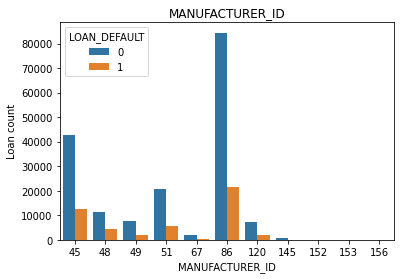

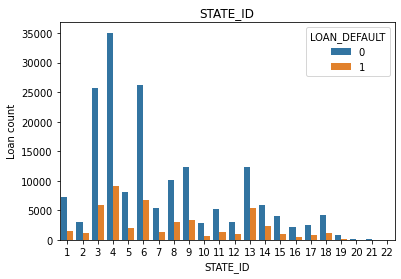

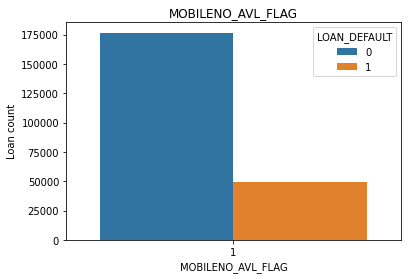

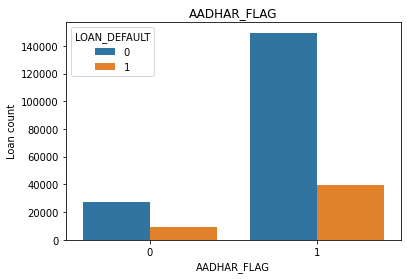

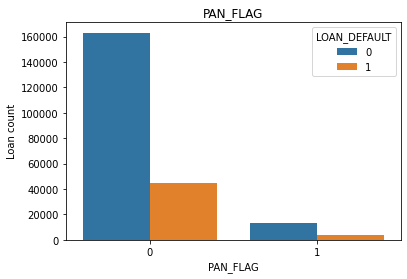

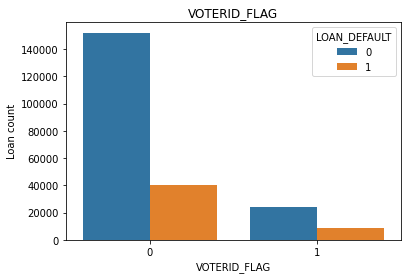

In [20]:
for feature in discrete_features[:6]:
    sns.countplot(data=df, x=feature, hue='LOAN_DEFAULT')
    plt.xlabel(feature)
    plt.ylabel('Loan count')
    plt.title(feature)
    plt.show()

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225493 entries, 0 to 233153
Data columns (total 34 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UNIQUEID                             225493 non-null  int64  
 1   DISBURSED_AMOUNT                     225493 non-null  float64
 2   ASSET_COST                           225493 non-null  int64  
 3   LTV                                  225493 non-null  float64
 4   EMPLOYMENT_TYPE                      225493 non-null  object 
 5   DISBURSAL_DATE                       225493 non-null  int64  
 6   MOBILENO_AVL_FLAG                    225493 non-null  int64  
 7   AADHAR_FLAG                          225493 non-null  int64  
 8   PAN_FLAG                             225493 non-null  int64  
 9   VOTERID_FLAG                         225493 non-null  int64  
 10  DRIVING_FLAG                         225493 non-null  int64  
 11  PASSPORT_FLAG

In [22]:
plot={1:[111],2:[121,122],3:[131,132,133],4:[221,222,223,224],5:[231,232,233,234,235],6:[231,232,233,234,235,236]}

In [23]:
### Getting the continous features of the dataset
continuous_features=[feature for feature in numerical_features if feature not in discrete_features+['UNIQUEID']]
continuous_features

['DISBURSED_AMOUNT',
 'ASSET_COST',
 'LTV',
 'BRANCH_ID',
 'SUPPLIER_ID',
 'CURRENT_PINCODE_ID',
 'EMPLOYEE_CODE_ID',
 'PERFORM_CNS_SCORE',
 'PRI_NO_OF_ACCTS',
 'PRI_ACTIVE_ACCTS',
 'PRI_CURRENT_BALANCE',
 'PRI_SANCTIONED_AMOUNT',
 'PRI_DISBURSED_AMOUNT',
 'SEC_NO_OF_ACCTS',
 'SEC_CURRENT_BALANCE',
 'SEC_SANCTIONED_AMOUNT',
 'SEC_DISBURSED_AMOUNT',
 'PRIMARY_INSTAL_AMT',
 'SEC_INSTAL_AMT']

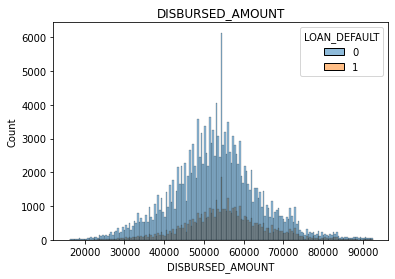

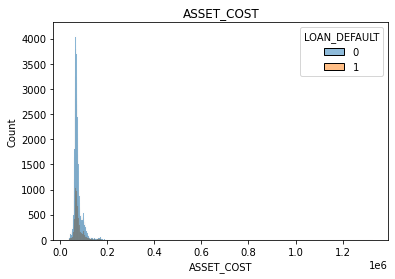

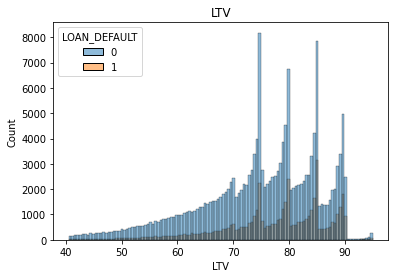

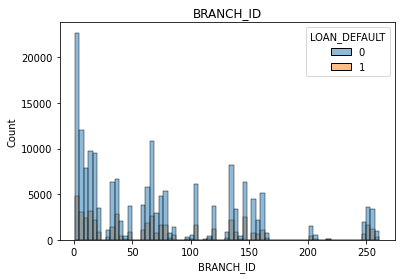

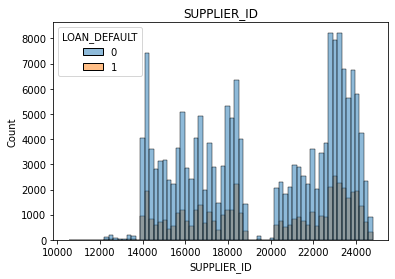

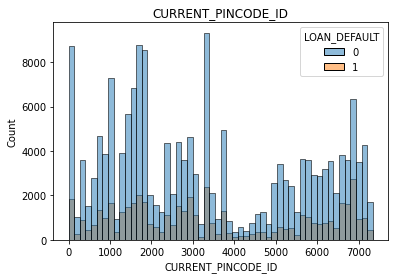

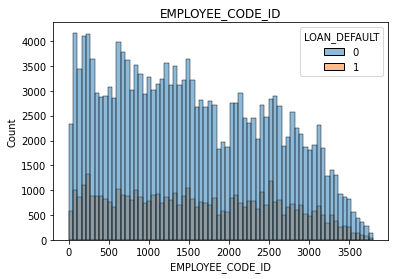

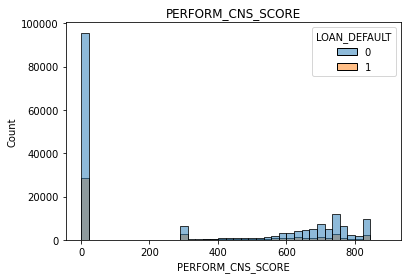

In [24]:
for feature in continuous_features[:8]:
    sns.histplot(data=df, x=feature, hue='LOAN_DEFAULT')
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

In [25]:
df2=df.copy()

In [26]:
#df['EMPLOYMENT_TYPE'].unique()

In [27]:
df[df.LOAN_DEFAULT==0].isna().sum()
#missing data is assymetrically missinng

UNIQUEID                               0
DISBURSED_AMOUNT                       0
ASSET_COST                             0
LTV                                    0
BRANCH_ID                              0
SUPPLIER_ID                            0
MANUFACTURER_ID                        0
CURRENT_PINCODE_ID                     0
DATE_OF_BIRTH                          0
EMPLOYMENT_TYPE                        0
DISBURSAL_DATE                         0
STATE_ID                               0
EMPLOYEE_CODE_ID                       0
MOBILENO_AVL_FLAG                      0
AADHAR_FLAG                            0
PAN_FLAG                               0
VOTERID_FLAG                           0
DRIVING_FLAG                           0
PASSPORT_FLAG                          0
PERFORM_CNS_SCORE                      0
PERFORM_CNS_SCORE_DESCRIPTION          0
PRI_NO_OF_ACCTS                        0
PRI_ACTIVE_ACCTS                       0
PRI_OVERDUE_ACCTS                      0
PRI_CURRENT_BALA

In [28]:
#in original data LOAN_DEFAULT 0 to 1 ratio is 3.60
# inn missing dat 0:1 ratio is 3.66
# since ratio will be preserved after omitting missing data therefore we delete missing rows 

In [29]:
# df=df.EMPLOYMENT_TYPE.dropna()

In [30]:
df.isna().sum()

UNIQUEID                               0
DISBURSED_AMOUNT                       0
ASSET_COST                             0
LTV                                    0
BRANCH_ID                              0
SUPPLIER_ID                            0
MANUFACTURER_ID                        0
CURRENT_PINCODE_ID                     0
DATE_OF_BIRTH                          0
EMPLOYMENT_TYPE                        0
DISBURSAL_DATE                         0
STATE_ID                               0
EMPLOYEE_CODE_ID                       0
MOBILENO_AVL_FLAG                      0
AADHAR_FLAG                            0
PAN_FLAG                               0
VOTERID_FLAG                           0
DRIVING_FLAG                           0
PASSPORT_FLAG                          0
PERFORM_CNS_SCORE                      0
PERFORM_CNS_SCORE_DESCRIPTION          0
PRI_NO_OF_ACCTS                        0
PRI_ACTIVE_ACCTS                       0
PRI_OVERDUE_ACCTS                      0
PRI_CURRENT_BALA

In [31]:
# df[df.duplicated()]

<AxesSubplot:>

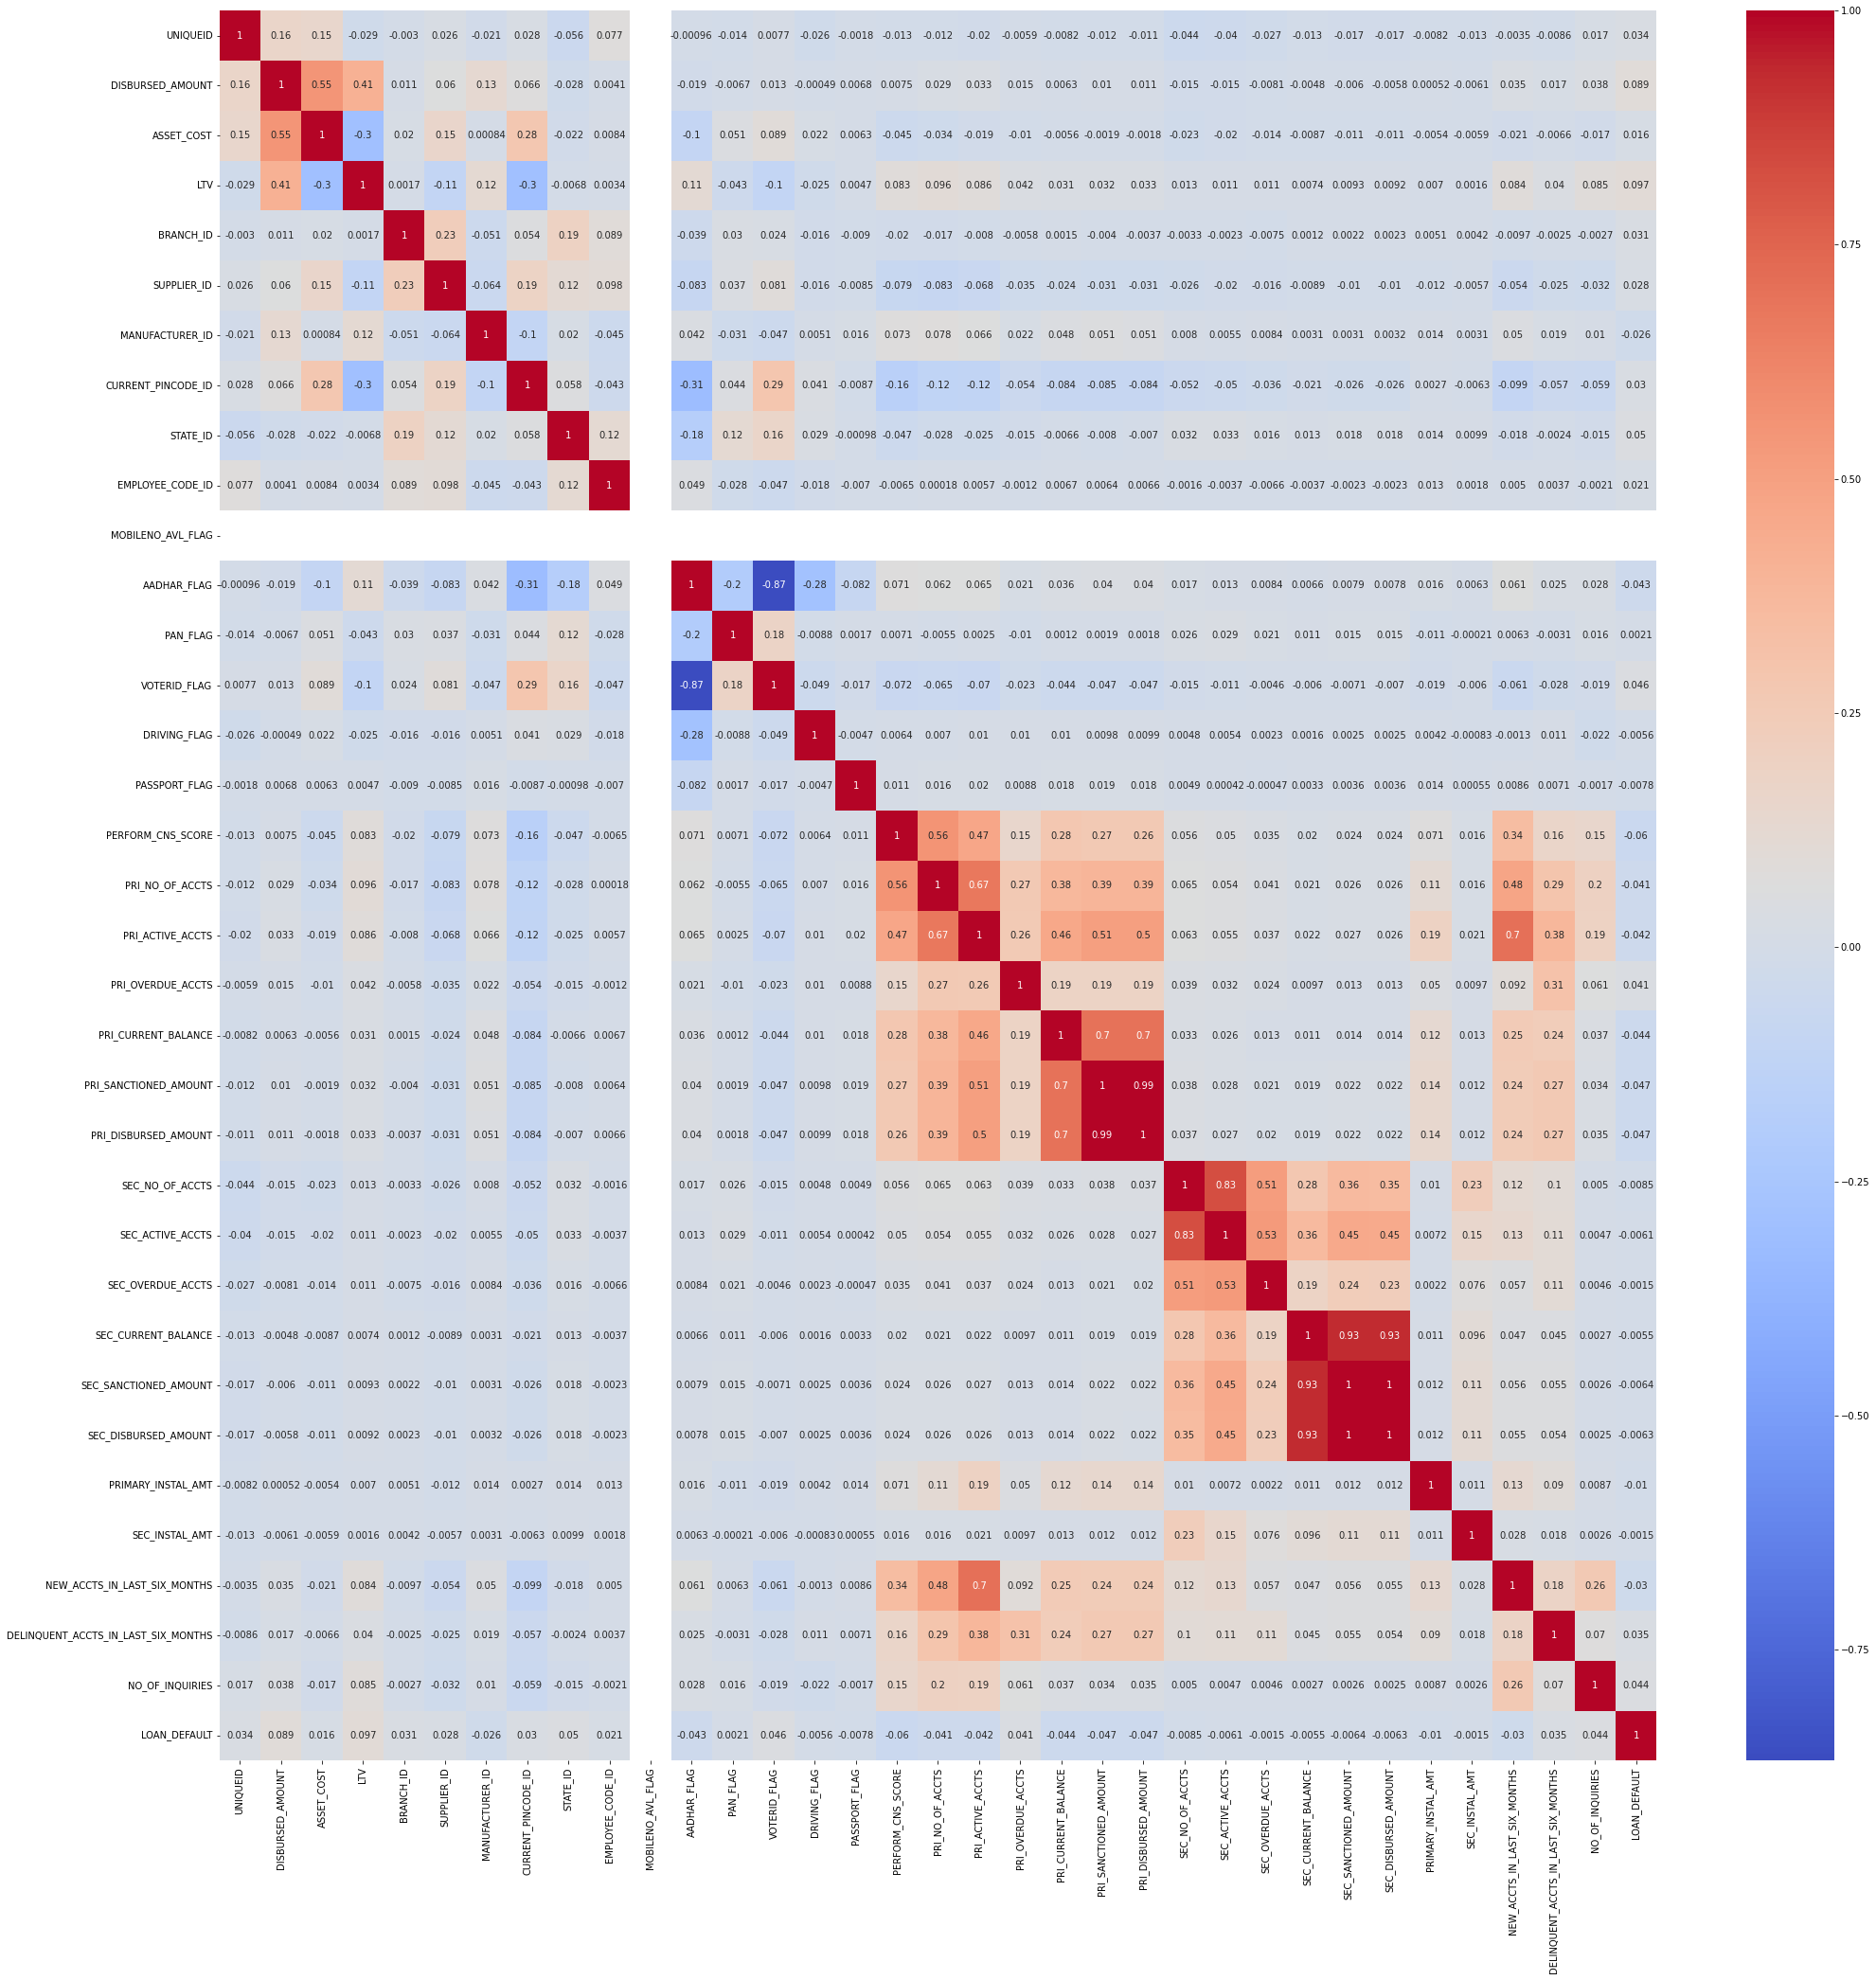

In [32]:
plt.figure(figsize=(34,34))
sns.heatmap(df2.corr(),annot=True, cmap="coolwarm")

In [33]:
#primary sactioned amount and primary disburused amount and secondARY a=sacntioned amount is very strongly correlated 

In [34]:
#mobile number is available for all fields

In [35]:
#MOBILENO_AVL_FLAG AADHAR_FLAG PAN_FLAG VOTERID_FLAG DRIVING_FLAG PASSPORT_FLAG are just for book=keeping purpose, so thy can be removed from data
#attributes removed 
#MOBILENO_AVL_FLAG AADHAR_FLAG PAN_FLAG VOTERID_FLAG DRIVING_FLAG PASSPORT_FLAG 
#PRI_SANCTIONED_AMOUNT PRI_DISBURSED_AMOUNT with 

In [36]:
train = train.drop([ 'UNIQUEID','PRI_SANCTIONED_AMOUNT' , 'SEC_SANCTIONED_AMOUNT', 'MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG', 'VOTERID_FLAG','DRIVING_FLAG','PASSPORT_FLAG'],axis=1)

In [37]:
train.rename(columns={'PRI_DISBURSED_AMOUNT': 'PRI_SANCTIONED_and_DISBURSED_AMOUNT'}, inplace=True)
train.rename(columns={'SEC_DISBURSED_AMOUNT': 'SEC_SANCTIONED_and_DISBURSED_AMOUNT'}, inplace=True)

In [38]:
def plot_box(feature, color):
    plt.figure(figsize=(10,6))
    plt.title("Box Plot of %s" % feature)
    sns.boxplot(train[feature].dropna(),color=color)
    plt.show()

In [39]:
 boxplot_columns=['DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 
        'DISBURSAL_DATE', 
       'PERFORM_CNS_SCORE', 'PRI_NO_OF_ACCTS',
       'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE',
       'PRI_SANCTIONED_and_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS',
       'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE',
       'SEC_SANCTIONED_and_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT',
       'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
       'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'AVERAGE_ACCT_AGE',
       'CREDIT_HISTORY_LENGTH', 'NO_OF_INQUIRIES']

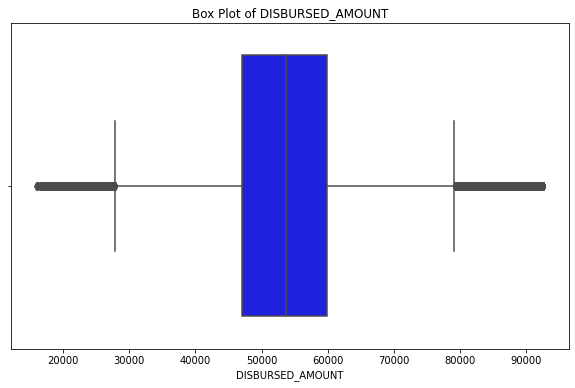

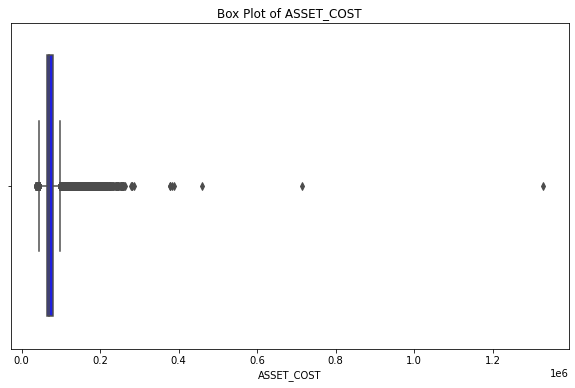

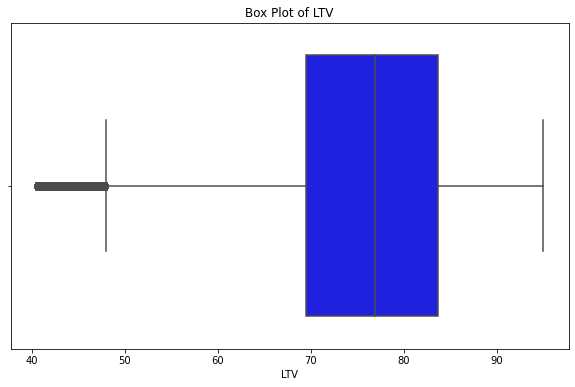

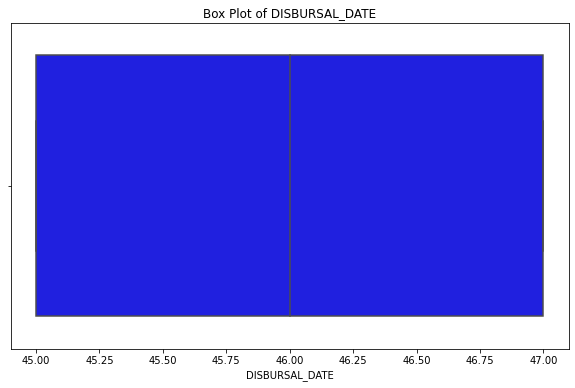

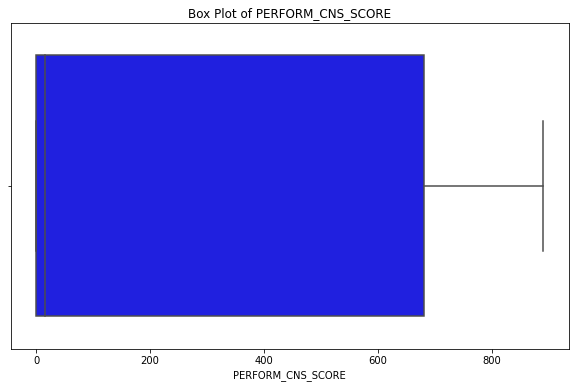

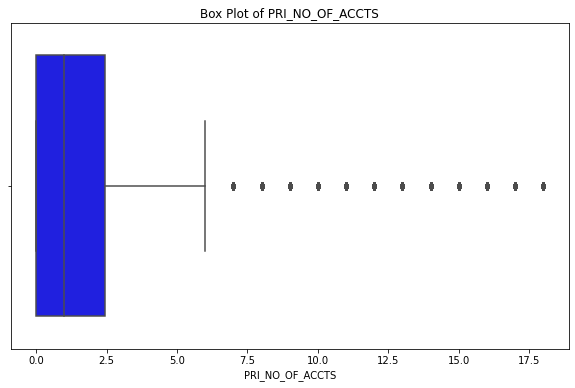

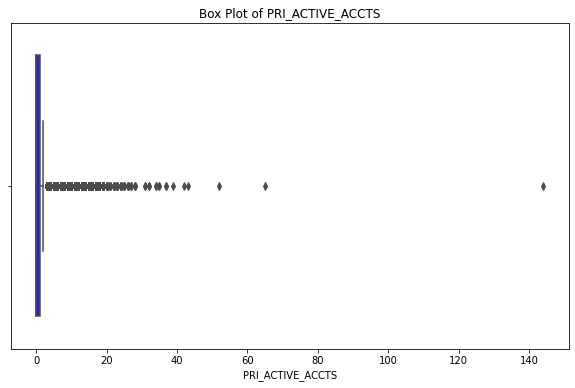

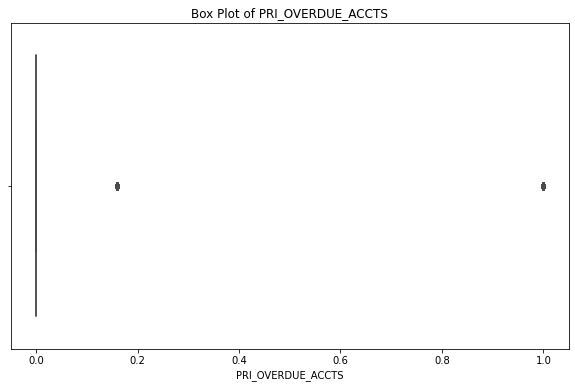

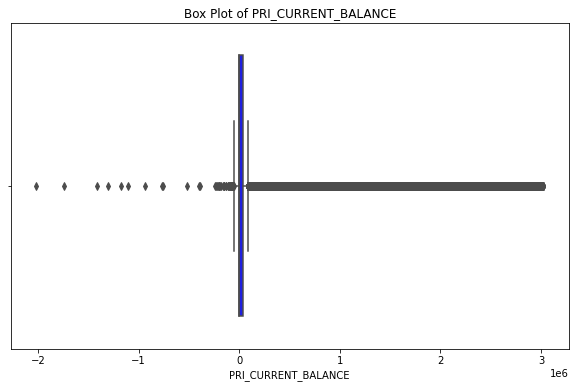

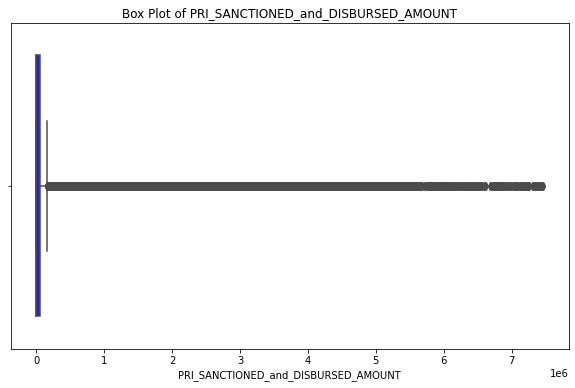

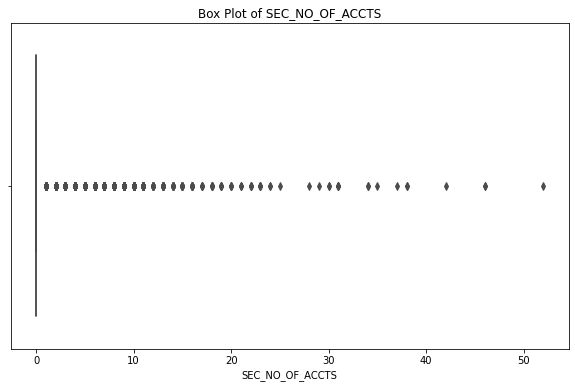

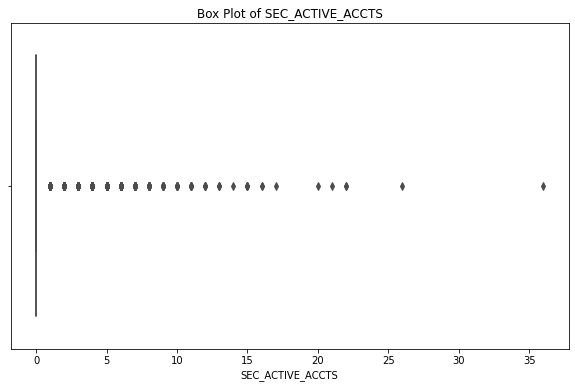

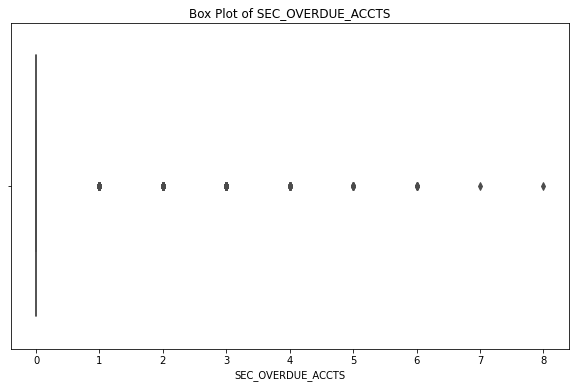

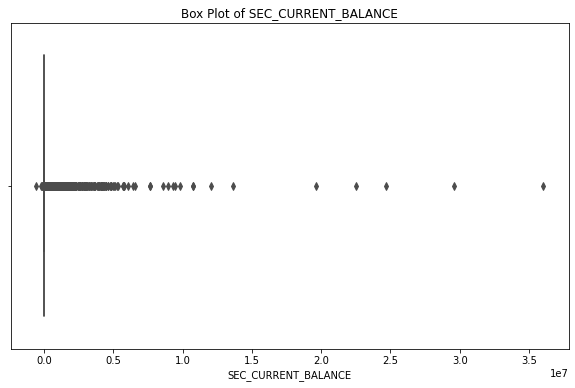

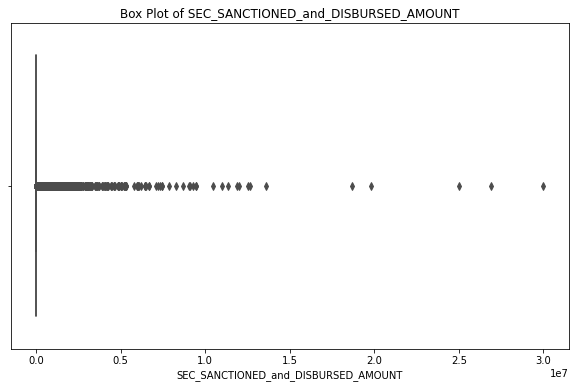

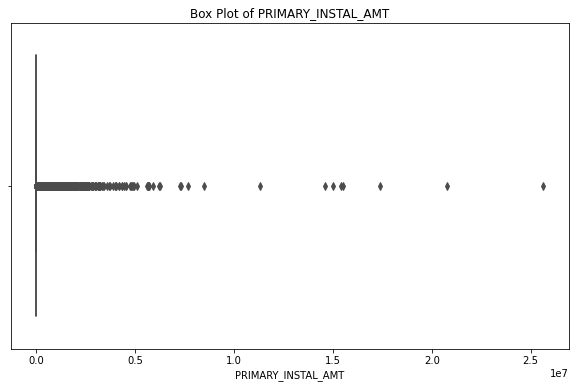

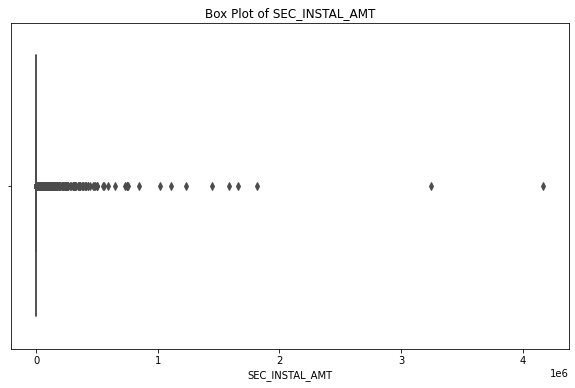

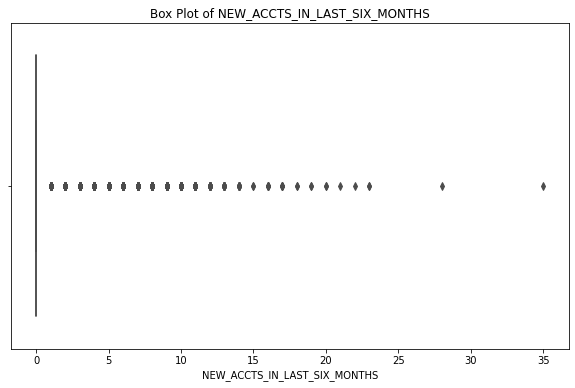

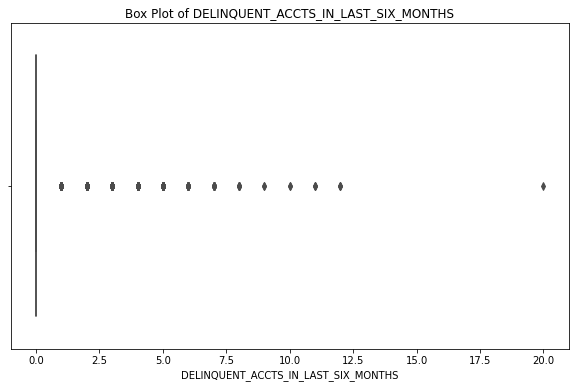

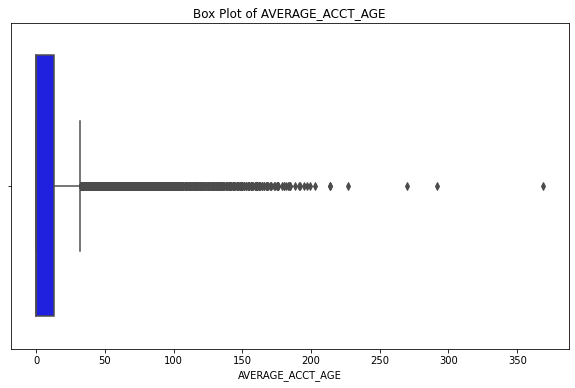

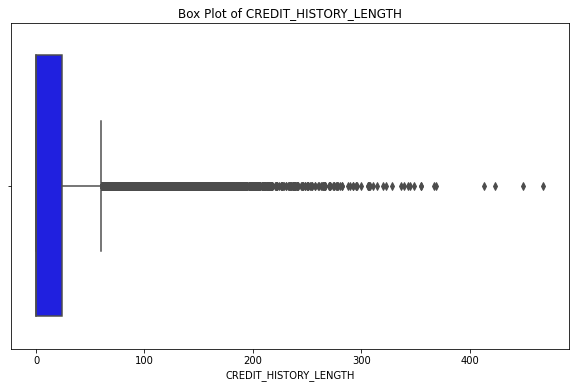

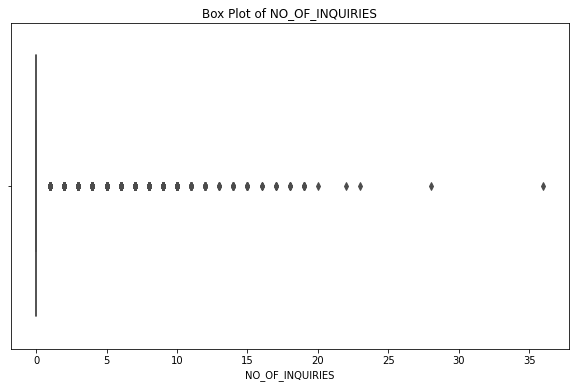

In [40]:
for column in boxplot_columns:
  plot_box(column,'blue')

In [41]:
# converting numerical data in str form to float
for i in range(len(boxplot_columns)):
  df2[boxplot_columns[i]] = list(np.float_(train[boxplot_columns[i]].to_list()))

In [42]:
# MinMax Normalization of numerical data
dfNormalized=pd.DataFrame()
for i in range(len(boxplot_columns)):
  col=train[boxplot_columns[i]].to_list()
  colSorted=sorted(df2[boxplot_columns[i]].to_list())
  NormList=[]
  for j in range(len(col)):
    a=100*(col[j]-colSorted[0])/(colSorted[-1]-colSorted[0])
    NormList.append(a)
  dfNormalized[boxplot_columns[i]]=NormList
dfNormalized.head()


,DISBURSED_AMOUNT,ASSET_COST,LTV,DISBURSAL_DATE,PERFORM_CNS_SCORE,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_and_DISBURSED_AMOUNT,...,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_and_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES
0,45.222531,1.656406,90.001835,100.0,0.000000,0.000000,0.000000,0.0,40.038974,0.00000,...,0.0,1.569752,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,40.743205,2.209831,60.062374,50.0,67.191011,5.555556,0.694444,100.0,40.586499,0.67252,...,0.0,1.569752,0.0,0.007764,0.0,0.0,5.0,6.233062,4.914530,0.000000
2,48.745450,1.885516,90.148597,100.0,0.000000,0.000000,0.000000,0.0,40.038974,0.00000,...,0.0,1.569752,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,54.271213,2.253408,88.038892,0.0,34.269663,16.666667,0.000000,0.0,40.038974,0.00000,...,0.0,1.569752,0.0,0.000121,0.0,0.0,0.0,2.168022,3.205128,2.777778
4,47.571143,1.803470,87.873785,50.0,0.000000,0.000000,0.000000,0.0,40.038974,0.00000,...,0.0,1.569752,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,2.777778


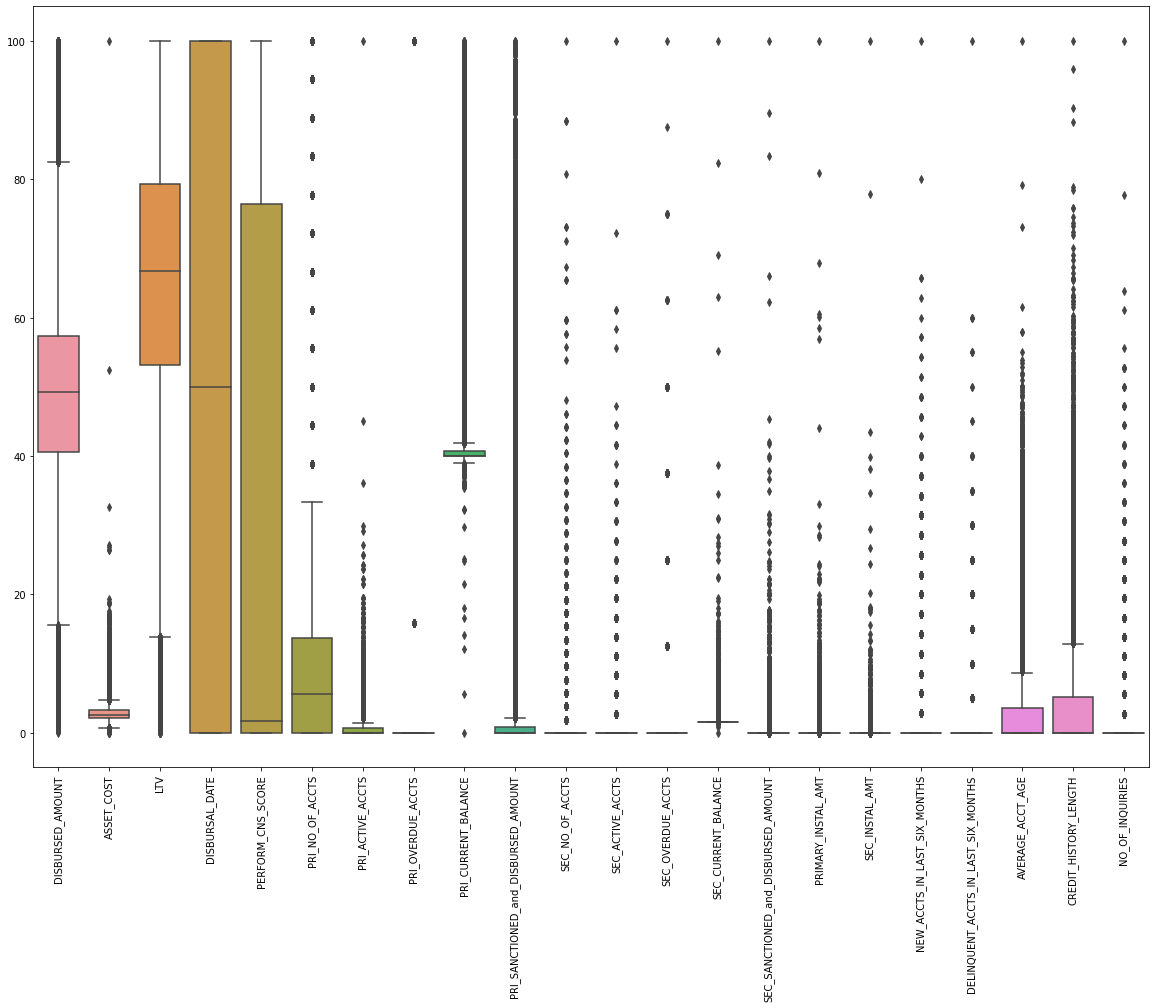

In [43]:
# boxplot of the MinMax Normalized values of numerical columns
fig = plt.figure(figsize=(20, 14))
plt.xticks(rotation=90)
sns.boxplot(data = dfNormalized)
plt.show()

In [44]:
train.describe()

,DISBURSED_AMOUNT,ASSET_COST,LTV,DISBURSAL_DATE,PERFORM_CNS_SCORE,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_and_DISBURSED_AMOUNT,...,SEC_CURRENT_BALANCE,SEC_SANCTIONED_and_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
count,225493.000000,2.254930e+05,225493.000000,225493.000000,225493.000000,225493.000000,225493.000000,225493.000000,2.254930e+05,2.254930e+05,...,2.254930e+05,2.254930e+05,2.254930e+05,2.254930e+05,225493.000000,225493.000000,225493.000000,225493.000000,225493.000000,225493.000000
mean,53620.859311,7.563113e+04,75.280560,45.872573,293.040449,2.001474,1.053767,0.091270,1.085117e+05,1.775055e+05,...,5.569682e+03,7.371104e+03,1.299246e+04,3.256845e+02,0.386602,0.098708,9.028302,16.453087,0.208845,0.217155
std,11097.451518,1.852758e+04,10.547173,0.834925,338.874784,3.275337,1.952015,0.281545,3.369341e+05,5.806243e+05,...,1.729281e+05,1.854703e+05,1.497084e+05,1.575617e+04,0.959668,0.386376,15.161620,28.676869,0.710085,0.412310
min,15919.000000,3.700000e+04,40.490000,45.000000,0.000000,0.000000,0.000000,0.000000,-2.018309e+06,0.000000e+00,...,-5.746470e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47069.000000,6.562500e+04,69.450000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53703.000000,7.080700e+04,76.890000,46.000000,15.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,59897.000000,7.896600e+04,83.730000,47.000000,680.000000,2.462360,1.000000,0.000000,3.630000e+04,6.299000e+04,...,0.000000e+00,0.000000e+00,2.045000e+03,0.000000e+00,0.000000,0.000000,13.000000,24.000000,0.000000,0.000000
max,92560.000000,1.328954e+06,95.000000,47.000000,890.000000,18.000000,144.000000,1.000000,3.022552e+06,7.464458e+06,...,3.603285e+07,3.000000e+07,2.564281e+07,4.170901e+06,35.000000,20.000000,369.000000,468.000000,36.000000,1.000000


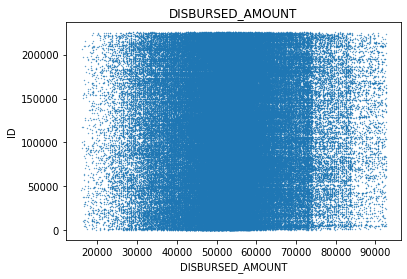

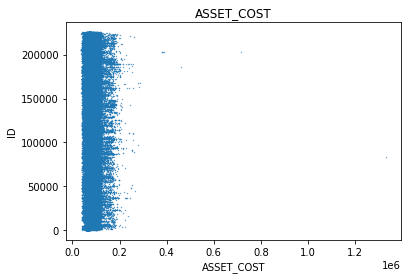

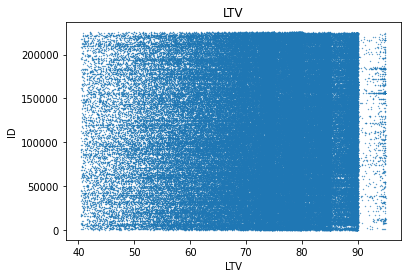

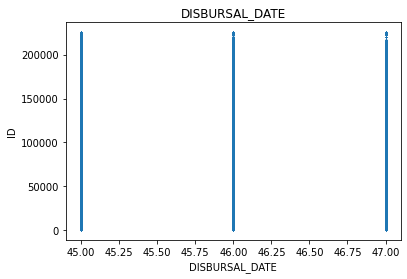

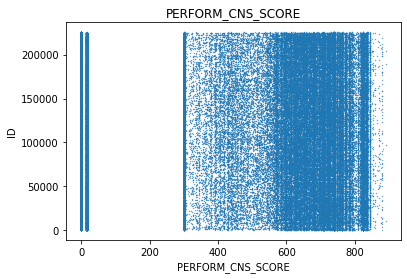

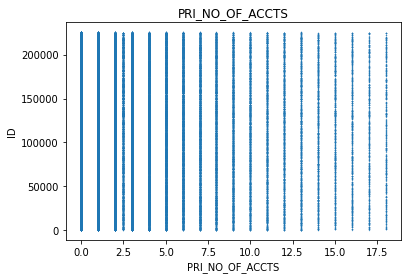

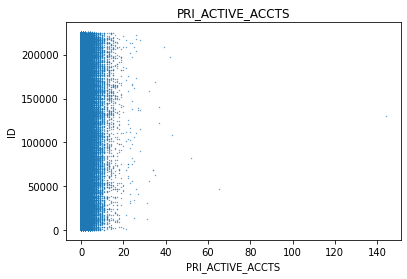

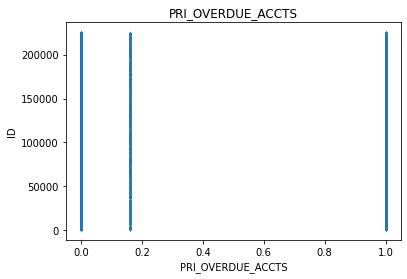

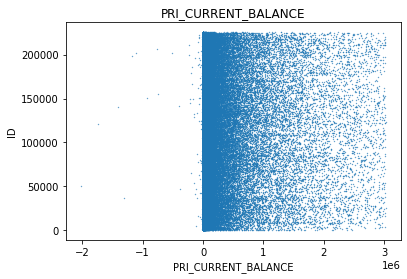

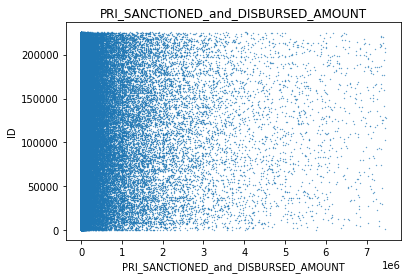

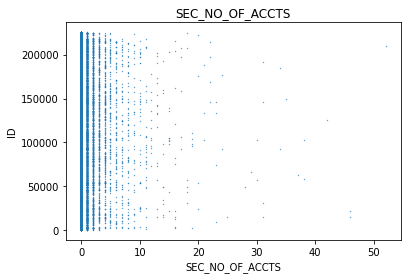

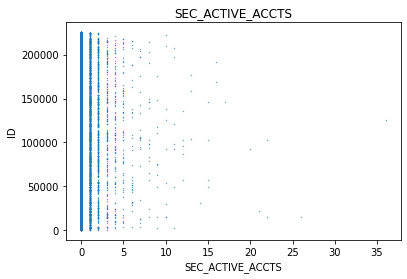

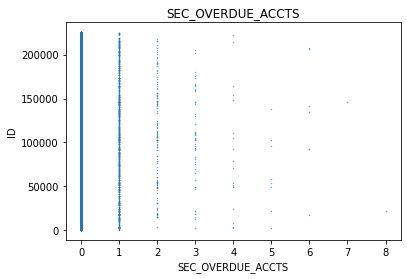

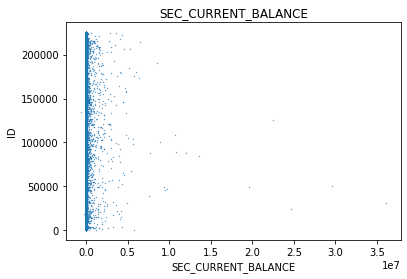

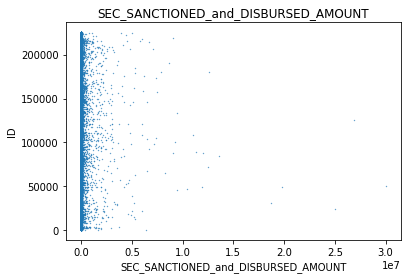

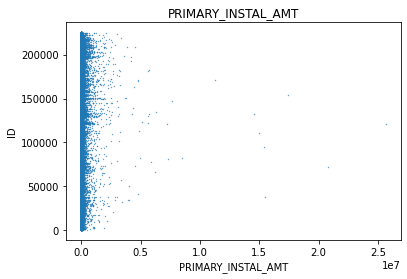

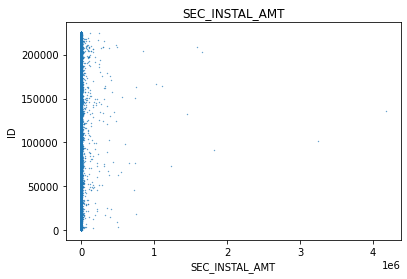

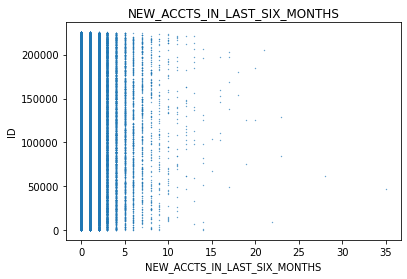

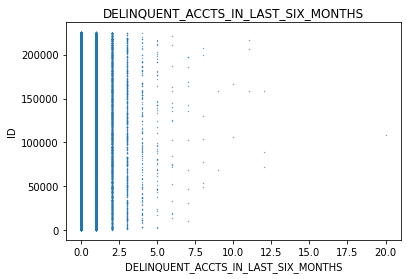

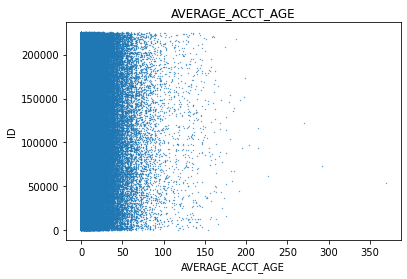

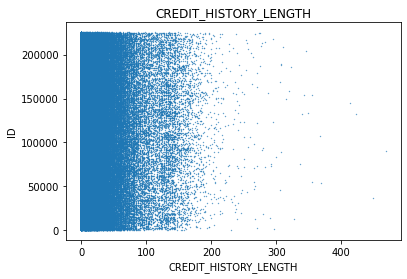

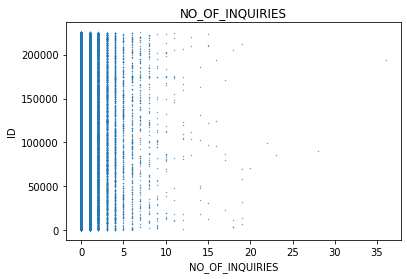

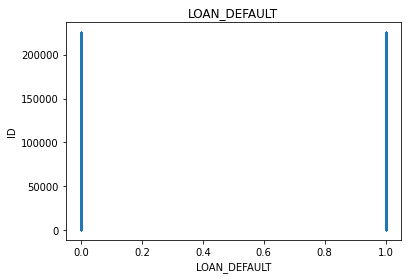

In [45]:
def scatterPlots():
    cols=train.columns
    UniqueID=[]
    for i in range(0,len(df2)):
      UniqueID.append(i+1)
    for col in cols:
        if (train[col].dtypes !='object'):
            fig1=plt.figure()
            ax1=plt.axes()
            plt.scatter(train[[col]],UniqueID,alpha=1,s=0.1)
            plt.title(col)
            ax1 = ax1.set(xlabel=col, ylabel='ID')
            plt.show()
scatterPlots()

In [46]:
# function to perform chiSquaredTest on 2 different attributes of data
def chiSquaredTest(listA,listB,labelA,labelB,labelC,labelD):
  X=[]
  a=0
  b=0
  c=0
  d=0
  for i in range(7043):
    m=int(listA[i])
    n=int(listB[i])
    if m==1 and n==1:
      a+=1
    elif m==0 and n==1:
      b+=1
    elif m==1 and n==0:
      c+=1
    elif m==0 and n==0:
      d+=1
  X.append(a)
  X.append(b)
  X.append(c)
  X.append(d)
  exp=[]
  o=(X[0]+X[2])*(X[0]+X[1])/7043
  p=(X[1]+X[3])*(X[0]+X[1])/7043
  q=(X[0]+X[2])*(X[2]+X[3])/7043
  r=(X[1]+X[3])*(X[2]+X[3])/7043
  exp.append(o)
  exp.append(p)
  exp.append(q)
  exp.append(r)
  box=[]
  boxExp=[]
  box.append([X[0],X[1],X[0]+X[1]])
  box.append([X[2],X[3],X[2]+X[3]])
  box.append([X[0]+X[2],X[1]+X[3],X[0]+X[1]+X[2]+X[3]])
  boxExp.append([exp[0],exp[1],exp[0]+exp[1]])
  boxExp.append([exp[2],exp[3],exp[2]+exp[3]])
  boxExp.append([exp[0]+exp[2],exp[1]+exp[3],exp[0]+exp[1]+exp[2]+exp[3]])
  boxDF=pd.DataFrame(box,columns=[labelA,labelB,"Total"],index=[labelC,labelD,"Total"])
  boxDFExp=pd.DataFrame(boxExp,columns=[labelA,labelB,"Total"],index=[labelC,labelD,"Total"])
  print("Calculated Table")
  print(boxDF)
  print()
  print("Expected Table")
  print(boxDFExp)
  chi2=0
  for i in range(4):
    chi2+=((X[i]-exp[i])**2)/exp[i]
  return chi2

In [47]:
df3=df.copy()
df3['EMPLOYMENT_TYPE'].replace(to_replace=['Salaried','Self employed'], value= [1,0], inplace = True)
df3['LOAN_DEFAULT'].replace(to_replace=['YES','NO'], value= [1,0], inplace = True)
# print(df3['EMPLOYMENT_TYPE'].to_list)
# print(df3['LOAN_DEFAULT'].to_list)
aa=(chiSquaredTest(df3['EMPLOYMENT_TYPE'].to_list(),df3['LOAN_DEFAULT'].to_list(),"Salaried","Self Employed","Loan Default","Loan Not Default"))
print()
print("Chi Squared value = ",aa)

Calculated Table
                  Salaried  Self Employed  Total
Loan Default           537            941   1478
Loan Not Default      2112           3453   5565
Total                 2649           4394   7043

Expected Table
                     Salaried  Self Employed   Total
Loan Default       555.902598     922.097402  1478.0
Loan Not Default  2093.097402    3471.902598  5565.0
Total             2649.000000    4394.000000  7043.0

Chi Squared value =  1.3038705107692794


In [48]:
train.head()

,DISBURSED_AMOUNT,ASSET_COST,LTV,EMPLOYMENT_TYPE,DISBURSAL_DATE,PERFORM_CNS_SCORE,PERFORM_CNS_SCORE_DESCRIPTION,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,...,SEC_CURRENT_BALANCE,SEC_SANCTIONED_and_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
0,50578.0,58400,89.55,Salaried,47,0,No Bureau History Available,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,47145.0,65550,73.23,Self employed,46,598,I-Medium Risk,1.0,1,1.0,...,0,0,1991,0,0,1,23,23,0,1
2,53278.0,61360,89.63,Self employed,47,0,No Bureau History Available,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,57513.0,66113,88.48,Self employed,45,305,L-Very High Risk,3.0,0,0.0,...,0,0,31,0,0,0,8,15,1,1
4,52378.0,60300,88.39,Self employed,46,0,No Bureau History Available,0.0,0,0.0,...,0,0,0,0,0,0,0,0,1,1


In [49]:
train_dummy = pd.get_dummies(train, prefix_sep='_', drop_first=False)
train_dummy.head()
train_dummy.columns


Index(['DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'DISBURSAL_DATE',
       'PERFORM_CNS_SCORE', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS',
       'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE',
       'PRI_SANCTIONED_and_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS',
       'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE',
       'SEC_SANCTIONED_and_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT',
       'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
       'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'AVERAGE_ACCT_AGE',
       'CREDIT_HISTORY_LENGTH', 'NO_OF_INQUIRIES', 'LOAN_DEFAULT',
       'EMPLOYMENT_TYPE_Salaried', 'EMPLOYMENT_TYPE_Self employed',
       'PERFORM_CNS_SCORE_DESCRIPTION_A-Very Low Risk',
       'PERFORM_CNS_SCORE_DESCRIPTION_B-Very Low Risk',
       'PERFORM_CNS_SCORE_DESCRIPTION_C-Very Low Risk',
       'PERFORM_CNS_SCORE_DESCRIPTION_D-Very Low Risk',
       'PERFORM_CNS_SCORE_DESCRIPTION_E-Low Risk',
       'PERFORM_CNS_SCORE_DESCRIPTION_F-Low Risk',
       'PERFORM_CNS_SCORE_DE

In [50]:
y = train_dummy[['LOAN_DEFAULT']]
X= train_dummy.loc[:, train_dummy.columns != 'LOAN_DEFAULT']
X.shape

(225493, 44)

In [51]:
np.any(np.isnan(X))

False

In [52]:
X = X.fillna(0)
X.shape

(225493, 44)

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 100)

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

**Random Forest**

In [54]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

In [55]:
print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, rfc_pred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",(accuracy_score(y_test, rfc_pred))*100)

Confusion Matrix

          Positive  Negative
Positive     41511      2613
Negative     11077      1173

Accuracy  75.71575549011956


In [56]:
print("F1 Score ",f1_score(y_test, rfc_pred))
print("Recall Score ",recall_score(y_test, rfc_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, rfc_pred))

F1 Score  0.14629583437266153
Recall Score  0.09575510204081633
Balanced Accuracy Score  0.5182678148224207


**Logistic Regression**

In [57]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression() 
logmodel.fit(X_train,y_train)
logpred = logmodel.predict(X_test)

In [58]:
print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, logpred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, logpred))*100)

Confusion Matrix

          Positive  Negative
Positive     44124         0
Negative     12250         0

Accuracy  100


In [59]:
print(classification_report(y_test,logpred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     44124
           1       0.00      0.00      0.00     12250

    accuracy                           0.78     56374
   macro avg       0.39      0.50      0.44     56374
weighted avg       0.61      0.78      0.69     56374



**Linear Regression**

In [60]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression() 
regr.fit(X_train, y_train)
regPred=regr.predict(X_test)

In [61]:
print("Confusion Matrix\n")
#using threshold of 0.5 below this as 0 and above it as 1
regPred = np.where(regPred<0.5,0,1)
confusionMatrix=confusion_matrix(y_test, regPred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, regPred),2)*100)

Confusion Matrix

          Positive  Negative
Positive     44099        25
Negative     12238        12

Accuracy  78.0


In [62]:
print(classification_report(y_test,regPred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     44124
           1       0.32      0.00      0.00     12250

    accuracy                           0.78     56374
   macro avg       0.55      0.50      0.44     56374
weighted avg       0.68      0.78      0.69     56374



**Stochastic Gradient Descent**

In [63]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss= "modified_huber", shuffle = True, random_state= 101).fit(X_train, y_train)

sgd_pred = sgd.predict(X_test)

In [64]:
print("Confusion Matrix\n")

confusionMatrix=confusion_matrix(y_test, sgd_pred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, sgd_pred),2)*100)

Confusion Matrix

          Positive  Negative
Positive     20939     23185
Negative      4895      7355

Accuracy  50.0


In [65]:
print(classification_report(y_test,sgd_pred))

              precision    recall  f1-score   support

           0       0.81      0.47      0.60     44124
           1       0.24      0.60      0.34     12250

    accuracy                           0.50     56374
   macro avg       0.53      0.54      0.47     56374
weighted avg       0.69      0.50      0.54     56374



**Naive Bayes**

In [66]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB().fit(X_train, y_train)
nb_pred = nb.predict(X_test)

In [67]:
print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, nb_pred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, nb_pred),2)*100)

Confusion Matrix

          Positive  Negative
Positive      6316     37808
Negative      1128     11122

Accuracy  31.0


In [68]:
print(classification_report(y_test,nb_pred))

              precision    recall  f1-score   support

           0       0.85      0.14      0.24     44124
           1       0.23      0.91      0.36     12250

    accuracy                           0.31     56374
   macro avg       0.54      0.53      0.30     56374
weighted avg       0.71      0.31      0.27     56374



**Decision Tree**

In [69]:
from sklearn.tree import DecisionTreeClassifier

#giving same output for both gini and entropy
dtree = DecisionTreeClassifier(random_state= 100).fit(X_train, y_train)
dtree_pred = dtree.predict(X_test)

In [70]:
print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, dtree_pred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, dtree_pred),2)*100)

Confusion Matrix

          Positive  Negative
Positive     34446      9678
Negative      9044      3206

Accuracy  67.0


In [71]:
print(classification_report(y_test,dtree_pred))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79     44124
           1       0.25      0.26      0.26     12250

    accuracy                           0.67     56374
   macro avg       0.52      0.52      0.52     56374
weighted avg       0.67      0.67      0.67     56374



**Artificial Neural Network**

In [72]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier( activation='relu', solver='sgd', max_iter=500,learning_rate='adaptive')
mlp.fit(X_train,y_train)
mlp_pred = mlp.predict(X_test)

In [73]:
print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, mlp_pred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, mlp_pred),2)*100)

Confusion Matrix

          Positive  Negative
Positive     44123         1
Negative     12250         0

Accuracy  78.0


In [74]:
print(classification_report(y_test,mlp_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     44124
           1       0.00      0.00      0.00     12250

    accuracy                           0.78     56374
   macro avg       0.39      0.50      0.44     56374
weighted avg       0.61      0.78      0.69     56374



**AdaBoost**

In [75]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=1000,
                         learning_rate=0.5)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)

In [76]:
print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, ada_pred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, ada_pred),2)*100)

Confusion Matrix

          Positive  Negative
Positive     44014       110
Negative     12166        84

Accuracy  78.0


In [77]:
print(classification_report(y_test,ada_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     44124
           1       0.43      0.01      0.01     12250

    accuracy                           0.78     56374
   macro avg       0.61      0.50      0.45     56374
weighted avg       0.71      0.78      0.69     56374



**K-Fold Cross Validation**

Logistic Regression

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


# a=[]
# b=[]
# model = LogisticRegression()
# for i in range(2,20):
#     cv = KFold(n_splits=i, random_state=1, shuffle=True)
#     scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#     print(mean(scores))
#     a.append(mean(scores))
#     b.append(i)

# plt.plot(b,a)
# plt.xlabel("K value")
# plt.ylabel("Accuracy on Train Set")

# print("Maximum Accuracy ",max(a))
# ind=a.index(max(a))
# print("Corresponding K value ",b[ind])

In [80]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = LogisticRegression()
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

In [81]:
from sklearn.model_selection import cross_val_predict

pred=cross_val_predict(model,X_test,y_test)
scores_test=cross_val_score(model,X_test,y_test,cv=b[ind])

In [82]:
print(mean(scores_test))
model.fit(X_train, y_train)
logRegKFold=model.predict(X_test)
print("\nAccuracy ",round(accuracy_score(y_test, logRegKFold),2)*100)

0.7826657740921921

Accuracy  78.0


In [83]:
print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, logRegKFold)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, logRegKFold),2)*100)

Confusion Matrix

          Positive  Negative
Positive     44124         0
Negative     12250         0

Accuracy  78.0


In [84]:
print(classification_report(y_test,logRegKFold))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     44124
           1       0.00      0.00      0.00     12250

    accuracy                           0.78     56374
   macro avg       0.39      0.50      0.44     56374
weighted avg       0.61      0.78      0.69     56374



In [87]:
from sklearn import metrics

# Logistic Regression
y_pred_proba1 = logmodel.predict_proba(X_test)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba1)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba1)

# Random Forest
y_pred_proba2 = rfc.predict_proba(X_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test,  y_pred_proba2)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba2)

# Random Forest
y_pred_proba3 = sgd.predict_proba(X_test)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(y_test,  y_pred_proba3)
auc3 = metrics.roc_auc_score(y_test, y_pred_proba3)

# Naive Bayes
y_pred_proba4 = nb.predict_proba(X_test)[::,1]
fpr4, tpr4, _ = metrics.roc_curve(y_test,  y_pred_proba4)
auc4 = metrics.roc_auc_score(y_test, y_pred_proba4)

# Decision Tree
y_pred_proba5 = dtree.predict_proba(X_test)[::,1]
fpr5, tpr5, _ = metrics.roc_curve(y_test,  y_pred_proba5)
auc5 = metrics.roc_auc_score(y_test, y_pred_proba5)

# Neural Network
y_pred_proba6 = mlp.predict_proba(X_test)[::,1]
fpr6, tpr6, _ = metrics.roc_curve(y_test,  y_pred_proba6)
auc6 = metrics.roc_auc_score(y_test, y_pred_proba6)

# Ada Boost
y_pred_proba7 = ada.predict_proba(X_test)[::,1]
fpr7, tpr7, _ = metrics.roc_curve(y_test,  y_pred_proba7)
auc7 = metrics.roc_auc_score(y_test, y_pred_proba7)

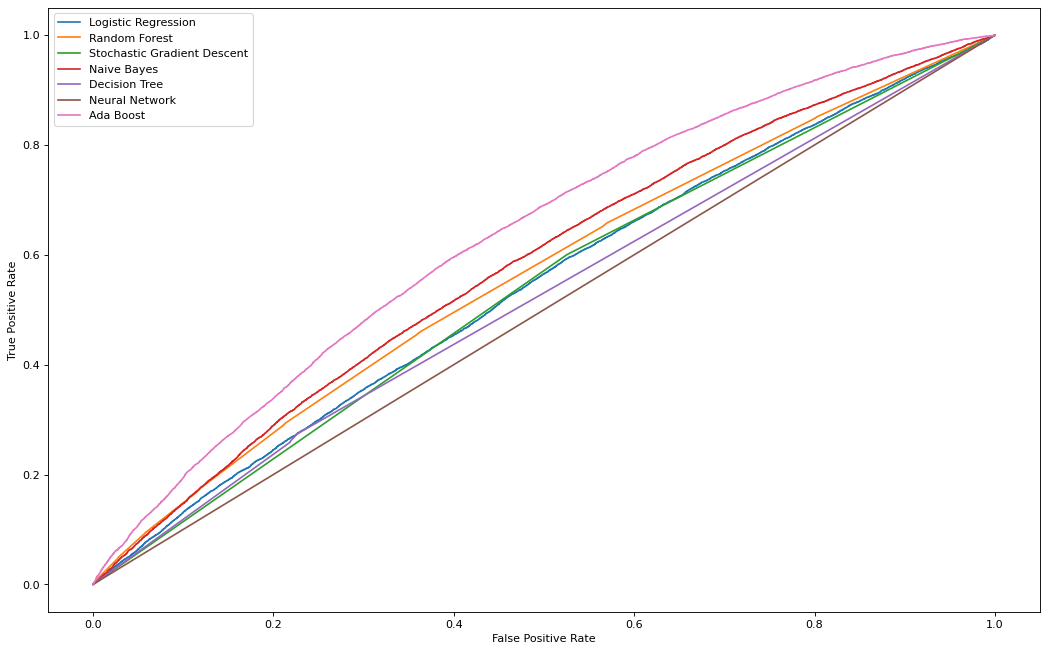

In [88]:
from matplotlib.pyplot import figure

figure(figsize=(16, 10), dpi=80)
plt.plot(fpr1,tpr1,label='Logistic Regression')
plt.plot(fpr2,tpr2,label='Random Forest')
plt.plot(fpr3,tpr3,label='Stochastic Gradient Descent')
plt.plot(fpr4,tpr4,label='Naive Bayes')
plt.plot(fpr5,tpr5,label='Decision Tree')
plt.plot(fpr6,tpr6,label='Neural Network')
plt.plot(fpr7,tpr7,label='Ada Boost')
# plt.plot([0,1],[0,1],label='Diagonal')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

**SMOTE**

In [90]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_resample(X_train, y_train)
# X_train, y_train = sm.fit_sample(X_train, y_train)

Stochiastic Gradient Descent

In [91]:
from sklearn.linear_model import SGDClassifier

# train model
sgd = SGDClassifier(loss= "modified_huber", shuffle = True, random_state= 101).fit(X_train, y_train)

# predict on test set
sgd_pred = sgd.predict(X_test)
print(confusion_matrix(y_test, sgd_pred))
print(round(accuracy_score(y_test, sgd_pred),2)*100)


[[ 7354 36882]
 [ 1393 10745]]
32.0


Decision Tree

In [92]:
from sklearn.tree import DecisionTreeClassifier

# train model
dtree = DecisionTreeClassifier(max_depth = 10, random_state= 101, max_features =None , min_samples_leaf = 30).fit(X_train, y_train)

# predict on test set
dtree_pred = dtree.predict(X_test)
print(confusion_matrix(y_test, dtree_pred))
print(round(accuracy_score(y_test, dtree_pred),2)*100)


[[38548  5688]
 [ 9843  2295]]
72.0


Random Forest

In [93]:
from sklearn.ensemble import RandomForestClassifier

# train model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test, rfc_pred))
print(round(accuracy_score(y_test, rfc_pred),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, rfc_pred))
print("F1 Score ",f1_score(y_test, rfc_pred))
print("Recall Score ",recall_score(y_test, rfc_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, rfc_pred))

[[38751  5485]
 [ 9969  2169]]
73.0
Accuracy of model  0.7258665342179018
F1 Score  0.21917946645109135
Recall Score  0.1786950074147306
Balanced Accuracy Score  0.5273504877023015


Logistic Regression

In [97]:
from sklearn.linear_model import LogisticRegression

# train model
logmodel = LogisticRegression() 
logmodel.fit(X_train,y_train)
logpred = logmodel.predict(X_test)

print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, logpred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, logpred))*100)

print(classification_report(y_test,logpred))

Confusion Matrix

          Positive  Negative
Positive     21348     22888
Negative      4526      7612

Accuracy  100
              precision    recall  f1-score   support

           0       0.83      0.48      0.61     44236
           1       0.25      0.63      0.36     12138

    accuracy                           0.51     56374
   macro avg       0.54      0.55      0.48     56374
weighted avg       0.70      0.51      0.55     56374



In [98]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB().fit(X_train, y_train)
nb_pred = nb.predict(X_test)

print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, nb_pred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, nb_pred),2)*100)

print(classification_report(y_test,nb_pred))

Confusion Matrix

          Positive  Negative
Positive      3645     40591
Negative       625     11513

Accuracy  27.0
              precision    recall  f1-score   support

           0       0.85      0.08      0.15     44236
           1       0.22      0.95      0.36     12138

    accuracy                           0.27     56374
   macro avg       0.54      0.52      0.25     56374
weighted avg       0.72      0.27      0.20     56374



**Neural Network**

In [99]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier( activation='relu', solver='sgd', max_iter=500,learning_rate='adaptive')
mlp.fit(X_train,y_train)
mlp_pred = mlp.predict(X_test)

print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, mlp_pred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, mlp_pred),2)*100)

print(classification_report(y_test,mlp_pred))

Confusion Matrix

          Positive  Negative
Positive         1     44235
Negative         1     12137

Accuracy  22.0
              precision    recall  f1-score   support

           0       0.50      0.00      0.00     44236
           1       0.22      1.00      0.35     12138

    accuracy                           0.22     56374
   macro avg       0.36      0.50      0.18     56374
weighted avg       0.44      0.22      0.08     56374



**Ada Boost**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=1000,
                         learning_rate=0.5)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)

print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, ada_pred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, ada_pred),2)*100)

print(classification_report(y_test,ada_pred))

In [ ]:
from sklearn import metrics

# Logistic Regression
y_pred_proba1 = logmodel.predict_proba(X_test)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba1)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba1)

# Random Forest
y_pred_proba2 = rfc.predict_proba(X_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test,  y_pred_proba2)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba2)

# Random Forest
y_pred_proba3 = sgd.predict_proba(X_test)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(y_test,  y_pred_proba3)
auc3 = metrics.roc_auc_score(y_test, y_pred_proba3)

# Naive Bayes
y_pred_proba4 = nb.predict_proba(X_test)[::,1]
fpr4, tpr4, _ = metrics.roc_curve(y_test,  y_pred_proba4)
auc4 = metrics.roc_auc_score(y_test, y_pred_proba4)

# Decision Tree
y_pred_proba5 = dtree.predict_proba(X_test)[::,1]
fpr5, tpr5, _ = metrics.roc_curve(y_test,  y_pred_proba5)
auc5 = metrics.roc_auc_score(y_test, y_pred_proba5)

# Neural Network
y_pred_proba6 = mlp.predict_proba(X_test)[::,1]
fpr6, tpr6, _ = metrics.roc_curve(y_test,  y_pred_proba6)
auc6 = metrics.roc_auc_score(y_test, y_pred_proba6)

# Ada Boost
y_pred_proba7 = ada.predict_proba(X_test)[::,1]
fpr7, tpr7, _ = metrics.roc_curve(y_test,  y_pred_proba7)
auc7 = metrics.roc_auc_score(y_test, y_pred_proba7)

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(16, 10), dpi=80)
plt.plot(fpr1,tpr1,label='Logistic Regression')
plt.plot(fpr2,tpr2,label='Random Forest')
plt.plot(fpr3,tpr3,label='Stochastic Gradient Descent')
plt.plot(fpr4,tpr4,label='Naive Bayes')
plt.plot(fpr5,tpr5,label='Decision Tree')
plt.plot(fpr6,tpr6,label='Neural Network')
plt.plot(fpr7,tpr7,label='Ada Boost')
# plt.plot([0,1],[0,1],label='Diagonal')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

**Upsampling**

In [ ]:
y = train_dummy[['LOAN_DEFAULT']]
X= train_dummy.loc[:, train_dummy.columns != 'LOAN_DEFAULT']
X.shape

In [ ]:
from sklearn.utils import resample

X = pd.concat([X_train, y_train], axis=1)

not_fraud = X[X.LOAN_DEFAULT==0]
fraud = X[X.LOAN_DEFAULT==1]

In [ ]:
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

upsampled = pd.concat([not_fraud, fraud_upsampled])

upsampled.LOAN_DEFAULT.value_counts()

y_train = upsampled.LOAN_DEFAULT
X_train = upsampled.drop('LOAN_DEFAULT', axis=1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# train model
dtree = DecisionTreeClassifier(max_depth = 10, random_state= 101, max_features =None , min_samples_leaf = 30).fit(X_train, y_train)

# predict on test set
dtree_pred = dtree.predict(X_test)
print(confusion_matrix(y_test, dtree_pred))
print(round(accuracy_score(y_test, dtree_pred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

[[35051  9091]
 [15467 28654]]
72.0


In [ ]:
from sklearn.linear_model import SGDClassifier

# train model
sgd = SGDClassifier(loss= "modified_huber", shuffle = True, random_state= 101).fit(X_train, y_train)

# predict on test set
sgd_pred = sgd.predict(X_test)
print(confusion_matrix(y_test, sgd_pred))
print(round(accuracy_score(y_test, sgd_pred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

[[ 1453 42689]
 [ 1016 43105]]
50.0


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, sgd_pred))
print("F1 Score ",f1_score(y_test, sgd_pred))
print("Recall Score ",recall_score(y_test, sgd_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, sgd_pred))

Accuracy of model  0.5048321493717639
F1 Score  0.6635877304391333
Recall Score  0.9769724167629927
Balanced Accuracy Score  0.5049444567617238


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# train model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test, rfc_pred))
print(round(accuracy_score(y_test, rfc_pred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, rfc_pred))
print("F1 Score ",f1_score(y_test, rfc_pred))
print("Recall Score ",recall_score(y_test, rfc_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, rfc_pred))

[[40040  4102]
 [14461 29660]]
79.0
Accuracy of model  0.7896853721264856
F1 Score  0.7616553034680226
Recall Score  0.6722422429228712
Balanced Accuracy Score  0.7896574360824314


**DownSampling**

In [ ]:
y = train_dummy[['LOAN_DEFAULT']]
X= train_dummy.loc[:, train_dummy.columns != 'LOAN_DEFAULT']
X.shape

(225493, 44)

In [ ]:
from sklearn.utils import resample
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X.LOAN_DEFAULT==0]
fraud = X[X.LOAN_DEFAULT==1]

# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.LOAN_DEFAULT.value_counts()

y_train = downsampled.LOAN_DEFAULT
X_train = downsampled.drop('LOAN_DEFAULT', axis=1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# train model
dtree = DecisionTreeClassifier(max_depth = 10, random_state= 101, max_features =None , min_samples_leaf = 30).fit(X_train, y_train)

# predict on test set
dtree_pred = dtree.predict(X_test)
print(confusion_matrix(y_test, dtree_pred))
print(round(accuracy_score(y_test, dtree_pred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

[[35051  9091]
 [15467 28654]]
72.0


In [ ]:
from sklearn.linear_model import SGDClassifier

# train model
sgd = SGDClassifier(loss= "modified_huber", shuffle = True, random_state= 101).fit(X_train, y_train)

# predict on test set
sgd_pred = sgd.predict(X_test)
print(confusion_matrix(y_test, sgd_pred))
print(round(accuracy_score(y_test, sgd_pred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, sgd_pred))
print("F1 Score ",f1_score(y_test, sgd_pred))
print("Recall Score ",recall_score(y_test, sgd_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, sgd_pred))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# train model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test, rfc_pred))
print(round(accuracy_score(y_test, rfc_pred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, rfc_pred))
print("F1 Score ",f1_score(y_test, rfc_pred))
print("Recall Score ",recall_score(y_test, rfc_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, rfc_pred))